In [2]:
"""
Calculate electric field strength at a distance

23-Nov-22   CBL Original
24-Nov-22   CBL error in FS calculation
            Set this up to be calibrated against a known AM station
11-Dec-22   Added in measured strength and typical radio station data. 
            added in function for range to antenna. (This does not take into account the radiation pattern)
            
References:
https://ham.stackexchange.com/questions/10076/how-do-you-calculate-the-field-strength-at-a-given-distance
https://www.ahsystems.com/EMC-formulas-equations/field-intensity-calculation.php

Next look at the FCC field strength contours and match up.
"""
import numpy as np
import matplotlib.pyplot as plt
import math
#
# Geodesy stuff
#
#from pyproj import CRS
#from pyproj import Proj
from pyproj import Geod
from pygeodesy.ellipsoidalVincenty import LatLon

The next few methods are general in purpose. 

In [3]:
def Propagate(Source, Distance):
    """
    Propagate the field forward
    @Source   - Watts power at source
    @Distance - vector of distances (Volts)

    Propigate this, thinking of it as the Poynting vector
    """
    TestPoint       = Source/(4.0*np.pi*np.power(Distance,2.0))
    # return value in Watts/m^2
    return TestPoint

def Watts2FS(Source, Distance):
    """
    Compute the field strength in air based on 377 ohms free space impedance. 
    @Source   - Watts power at source
    @Distance - vector of distances (Volts)
    """
    TestPoint       = Propagate(Source, Distance)
    """
    P=E^2/R, E = sqrt(P*R)
    Use 377 ohms as free space impedance
    """
    ReferenceImpedance = 377.0 # Ohms
    Voltage = np.sqrt(TestPoint * ReferenceImpedance) # in volts/meter
    
    """ 
    24-Nov-22 Divide by the distance it has to be dV/ds, was V/s
    So If I don't do dV/ds my calculation is identical. dV/ds is much smaller, but this matches the article
    and seems to be within 1.5dB of the predicted testpoint which could be a matter of antenna gain. 
    """
    dV = np.diff(Voltage)
    ds = np.diff(Distance)
    FS = np.abs(dV/ds) # the differences are negative, but don't care
    return Voltage[1:]

def dBm2Watts(Source):
    """
    return Watts from input in dBm
    """
    return 1.0e-3 * np.power(10, Source/10)

def dBm2Volts(Source, Impedance):
    """
    @Source    - source power in dBm
    @Impedance - Impedance of system
    
    checked https://coretechgroup.com/dbm-calculator/
    returns RMS voltage. 
    """
    Power = dBm2Watts(Source)
    return np.sqrt(Power*Impedance)


In [4]:
class AntennaData:
    def __init__(self):
        """
        Default parameters
        Class AntennaData manages all the data associated with a specific radio station. We can make a list of 
        these. 
        """
        # 217 Locust Ave, Cortlandt Manor N.Y. 
        # https://mrjean1.github.io/PyGeodesy/docs/pygeodesy.ellipsoidalVincenty-module.html
        self.__my_LatLon = LatLon(41.308489, -73.893027)
        
        self.Frequency = 1000.0 # Frequency in kHz
        self.Power     = 1.0    # Watts at sourc
        self.Gain      = 1.0    # unitless, depends on gain pattern and azimuth relative to the Rx location
        self.LatLon    = LatLon(41.308489, -73.893027)
        self.call      = "AA9AL"
        
        self.distance  = self.LatLon.distanceTo(self.__my_LatLon)
        self.azimuth   = 0.0  # FIXME
        #self.geod      = Geod('+ellps=WGS84') # use proj4 style initialization string  

    def __str__(self):
        V,dBm = self.FS()
        #print(self.call, ' ', self.Frequency/1000, ' kHz Power:',self.Power, ' Watts, Gain:', self.AntennaGain )
        #print('Distance: ', self.distance, ' azimuth: ', self.azimuth)
        #print('Field strength at home:', V, ' V/m, ', dBm, 'dBm')
        return f"Station: {self.call}, Frequency: {self.Frequency/1000} Power: {self.Power} Watts Gain: {self.AntennaGain}"
    
    def setLatLon(self, Latitude, Longitude):
        """
        input Latitude and Longitude in decimal degrees. 
        This method will calculate the distance to home. 
        """
        self.LatLon    = LatLon(Latitude,Longitude)
        self.distance  = self.LatLon.distanceTo(self.__my_LatLon)
        # https://mrjean1.github.io/PyGeodesy/docs/pygeodesy.ellipsoidalVincenty.LatLon-class.html
        self.azimuth   = self.LatLon.initialBearingTo(self.__my_LatLon)
        # see how we get azimuth there
        #az12,az21,dist = self.geod.inv(Longitude, Latitude, self.__my_LatLon.lon, self.__my_LatLon.lat)
        #print ("testme az:", az12, " Distance:", dist)
        
    def setFrequency(self, f):
        """
        input frequency is in Hz
        """
        self.Frequency = f
    
    def setPower(self, p):
        self.Power = p # in Watts
    
    def setAntennaGain(self, g):
        self.AntennaGain = g
    
    def setCall(self, callsign):
        self.call = callsign
        
    def setParameters(self, callsign, Frequency, Power, AntennaGain, Latitude, Longitude):
        self.call        = callsign    # text
        self.Frequency   = Frequency   # Hz
        self.Power       = Power       # Watts
        self.AntennaGain = AntennaGain # Unitless
        self.setLatLon(Latitude,Longitude)

    def FS(self):
        TestPoint = Propagate(self.Power, self.distance) # volts/m^2
        dBm = 10.0 * np.log10(TestPoint/0.001)
        """
        P=E^2/R, E = sqrt(P*R)
        Use 377 ohms as free space impedance
        """
        ReferenceImpedance = 377.0 # Ohms
        Voltage = np.sqrt(TestPoint * ReferenceImpedance) # in volts/meter
        return Voltage, dBm
    
    def Print(self):
        """
        Print everything out
        """
        V,dBm = self.FS()
        print(self.call, ' ', self.Frequency/1000, ' kHz Power:',self.Power, ' Watts, Gain:', self.AntennaGain )
        print('Distance: ', self.distance, ' azimuth: ', self.azimuth)
        print('Field strength at home:', V, ' V/m, ', dBm, 'dBm')

In [6]:
""" Test the class """
"""
Zoomer radio CFZM 

Coordinates: 43°34′30″N 79°49′02″W
Distance = 546km
"""
CFZM = AntennaData()
# Input parameters
# Call sign, frequency in Hz, transmitter power in watts, antenna gain, Latitude and Longitude of antenna
CFZM.setParameters('CFZM', 740000, 50000, 1.0, 43.575, -79.817222)
CFZM.Print()
print(CFZM)


""" 
Use the AM radio station in Peekskill, New York.
https://en.wikipedia.org/wiki/WLNA
Antenna Coordinates: 41°18′31.13″N 73°54′59.0868″W, 1.9kM from house at Cortlandt Ave
https://www.fcc.gov/media/radio/figure8
https://www.fcc.gov/media/radio/am-query
F = 1420KHz
https://transition.fcc.gov/fcc-bin/amq?list=0&facid=54852
https://transition.fcc.gov/Bureaus/MB/Databases/AM_DA_patterns/445bc69f439c4205a14bc1b6063ebeb7-21377.pdf
Primary gain is to about 155 degrees magnetic.
Our location is aproximately 95 degrees magnetic, kind of side lobe but definiely gain. 
From the plot, seeing 161mV/m E field at 1kM from the antenna. (pretty strong!)
"""
WLNA = AntennaData()
WLNA.setParameters('WLNA', 1420000, 5000, 1.0, 41.30864722, -73.916413)
WLNA.Print()

CFZM   740.0  kHz Power: 50000  Watts, Gain: 1.0
Distance:  548411.4518605971  azimuth:  115.29543219688736
Field strength at home: 0.0022332854175294774  V/m,  -48.78452889878492 dBm
Station: CFZM, Frequency: 740.0 Power: 50000 Watts Gain: 1.0
WLNA   1420.0  kHz Power: 5000  Watts, Gain: 1.0
Distance:  1958.4594741186131  azimuth:  90.5063633263651
Field strength at home: 0.19775895386710732  V/m,  -9.840690381592264 dBm


Ratio between calculation and testpoint: [0.74128028]  dB  [-1.30017553]
Long Wire: 8.259309618407737
Transformer:  53.65930961840773
Resonant:  24.159309618407736


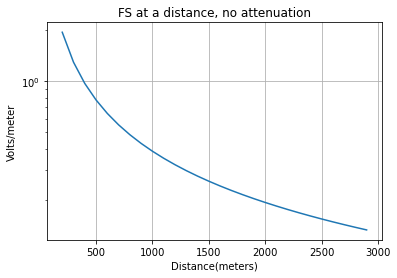

In [61]:
"""
11-Dec-22 CBL New form
"""
Power     = WLNA.Power
Distance  = np.arange(100.0, 3000.0, 100.0)  # step by 100m increments
FS        = Watts2FS(Power, Distance)
TestPoint = 261.0e-3   # Volts/meter at 1kM from chart
# Where is 1kM in distance vector? 
idx       = np.where(Distance==1000.0)
ratio     = TestPoint/FS[idx]
dBOff     = 10.0*np.log10(ratio)
print("Ratio between calculation and testpoint:", ratio, " dB ", dBOff)
"""
Off by approximately 468, (~27dB) why? 27dB is far too much for antenna gain alone. 
"""
plt.semilogy(Distance[1:],FS)
plt.title("FS at a distance, no attenuation")
plt.xlabel("Distance(meters)")
plt.ylabel("Volts/meter")
plt.grid(True)
"""
Check in with some measured values
"""
V,dBm = WLNA.FS()
print('Long Wire:', dBm + 18.1)
print('Transformer: ', dBm + 63.5 )
print('Resonant: ', dBm + 34)

Ratio between calculation and testpoint: []  dB  []


' OK this is way closer'

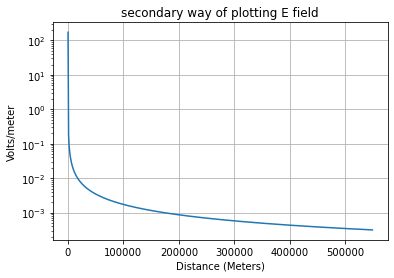

In [10]:
"""
Using the ham exchange calculation
"""
P_T = 1000.0 # transmitter Power in watts
G_T = 1.0    # Antenna gain
S = P_T * G_T/(4.0*np.pi*np.power(Distance,2.0))
E = np.sqrt(377.0*S)
plt.semilogy(Distance, E)
plt.title("secondary way of plotting E field")
plt.xlabel("Distance (Meters)")
plt.ylabel("Volts/meter")
plt.grid(True)

idx = np.where(Distance==1000.0)
ratio = TestPoint/E[idx]
dBOff = 10.0*np.log10(ratio)
print("Ratio between calculation and testpoint:", ratio, " dB ", dBOff)
""" OK this is way closer"""


Table of Local Frequencies <br>
<table>
  <tr>
      <th>Frequency (kHz) </th>
      <th>Call Sign</th> 
      <th>Power (Day/Night) </th>
      <th>Coordinates </th>
      <th> Notes </th>
  </tr>
  <tr>
      <td>570</td>
      <td>WMCA</td> 
      <td> 5 5</td>
      <td>  40.752879   -74.103754 </td>
      <td>Religious </td>
  </tr>
  <tr>
      <td>620</td>
      <td>WSNR</td> 
      <td> 3 7.6</td>
      <td>  40.798157   -74.106254</td>
      <td>Russian</td>
  </tr>
  <tr>
      <td>660</td>
      <td>WFAN</td> 
      <td> 50 </td>
      <td>  40.859822   -73.785410 </td>
      <td>Yankees/Talk clear channel </td>
  </tr>
  <tr>
      <td>710</td>
      <td>WOR</td> 
      <td> 50 <\td>
      <td> 40.797323   -74.089586<\td>
      <td>Talk</td>
  </tr>
  <tr>
      <td>770</td>
      <td>WABC</td> 
      <td> 50 </td>
      <td>  40.880655   -74.069308</td>
      <td>...</td>
  </tr>
  <tr>
      <td>820</td>
      <td>WNYC</td> 
      <td> 10/1</td>
      <td>  40.752879   -74.103754 </td>
      <td>...</td>
  </tr>
  <tr>
      <td>880</td>
      <td>WCBS</td> 
      <td> 50 <\td>
      <td> <\td>
      <td>50kw Clear channel</td>
  </tr>
  <tr>
      <td>910</td>
      <td>WRKL</td> 
      <td> 1/0.8</td>
      <td>  41.181206   -74.047642</td>
      <td> Polski </td>
  </tr>
  <tr>
      <td>930</td>
      <td>WPAT</td> 
      <td> 5 </td>
      <td> 40.849822   -74.182645 </td>
      <td></td>
  </tr>
  <tr>
      <td>970</td>
      <td>WNYM</td> 
      <td> 50/5 <\td>
      <td>  40.911210   -74.027917 <\td>
      <td> ... </td>
  </tr>
  <tr>
      <td>1010</td>
      <td>WINS</td> 
      <td> 50 </td>
      <td> 40.803989    -74.106254</td>
      <td></td>
  </tr>
  <tr>
      <td>1050</td>
      <td>WEPN</td> 
      <td> 50 </td>
      <td> 40.776768    -74.051807 </td>
      <td> </td>
  </tr>
  <tr>
      <td>1100</td>
      <td>WHLI</td> 
      <td> 10 </td>
      <td> </td>
      <td> </td>
  </tr>
  <tr>
      <td>1130</td>
      <td>WBBR</td> 
      <td> 50 </td>
      <td> 40.810934   -74.039585 </td>
      <td> </td>
  </tr>
  <tr>
      <td>1160</td>
      <td>WVNJ</td> 
      <td> 20/2.5 </td>
      <td>  41.056486  -74.249036</td>
      <td></td>
  </tr>
  <tr>
      <td>1190</td>
      <td>WLIB</td> 
      <td> 10/30</td>
      <td> 40.796768   -74.101254</td>
      <td> </td>
  </tr>
  <tr>
      <td> 1220 </td>
      <td> WGNY </td>
      <td> 10/0.18 </td>
      <td> 41.531483   -74.112922</td>
      <td>Oldies Middletown NY</td>      
  <tr>
      <td>1230</td>
      <td>WFAS</td> 
      <td> 1 </td>
      <td> </td>
      <td></td>
  </tr>
  <tr>
      <td>1240</td>
      <td>WGBB</td> 
      <td> 1 </td>
      <td> </td>
      <td></td>
  </tr>
  <tr>
      <td>1280</td>
      <td>WADO</td> 
      <td> 50/7.2 </td>
      <td>  40.826767   -74.075142</td>
      <td></td>
  </tr>
  <tr>
      <td>1330</td>
      <td>WWRV</td> 
      <td> 10/3.8 </td>
      <td> 40.845100   -74.019584 </td>
      <td>Spanish Religious</td>
  </tr>
  <tr>
      <td>1380</td>
      <td>WKDM</td> 
      <td> 5/13</td>
      <td>  40.820378   -74.067364 </td>
      <td>Chinese</td>
  </tr>
  <tr>
      <td>1420</td>
      <td>WLNA</td> 
      <td> 5/1</td>
      <td> 41.308705   -73.916249 </td>
      <td>Real country - Peekskill</td>
  </tr>
  <tr>
      <td>1430</td>
      <td>WNSW</td> 
      <td> 10/7</td>
      <td> 40.849822   -74.182645  </td>
      <td>Catholic</td>
  </tr>
  <tr>
      <td>1460</td>
      <td>WVOX</td> 
      <td> 0.5/0.122 </td>
      <td> 40.927599   -73.774577 </td>
      <td>Talk</td>
  </tr>
  <tr>
      <td>1480</td>
      <td>WZRC</td> 
      <td> 5 </td>
      <td> 40.845100   -74.019584 </td>
      <td>Chinese</td>
  </tr>
  <tr>
      <td>1520</td>
      <td>WTHE</td> 
      <td> XXX </td>
      <td> XXX </td>
      <td>Gospel</td>
  </tr>
  <tr>
      <td>1520</td>
      <td>WJDM</td> 
      <td> 1/0.278 </td>
      <td>  </td>
      <td>Gospel</td>
  </tr>
  <tr>
      <td>1530</td>
      <td>WJDM</td> 
      <td> 10/0.5</td>
      <td> </td>
      <td>Spanish religious</td>
  </tr>
  <tr>
      <td>1560</td>
      <td>WFME</td> 
      <td> 50 </td>
      <td> </td>
      <td>Christian</td>
  </tr>
  <tr>
      <td>1600</td>
      <td>WWRL</td> 
      <td> 25/5</td>
      <td> </td>
      <td> Mexican religion</td>
  </tr>
  <tr>
      <td>1660</td>
      <td>WWRU</td> 
      <td> 10 </td>
      <td> </td>
      <td>Korean</td>
  </tr>
</table>
<br>
<hr>
<a href = "http://www.nyradioguide.com/amlist1.htm"> Reference </a>

In [11]:
def MeasuredWLNA_Longwire():
    # Longwire into scope channel 1 20MHz bandwidth limited, 1Mohm input
    # The ground was not directly connected to the input. 
    Frequency = 1420.0e3
    Value     = [-10.5, -10.25, -18.1]     # dBm

def MeasuredTransformer():
    """
    This time I used a configuration where the longwire went through a series of windings to ground
    and the scope, also set to 20MHz 1Mohm, was put across another loop.    
    """
    Frequency = [1420, 880, 780, 710, 660, 561]
    Value     = [-63.5, -88.7, -88.7, -83, -75, -63]

def MeasuredResonance():
    """
    I put a third circuit in the game which was a resonant circuit. On resonance: 
    """
    Frequency = [1420] # kHz
    Amplitude = [-34]  # dBm